Bitcoin Data:
        time     high      low     open  volumefrom      volumeto    close  \
0 2019-10-17  8145.50  7948.95  8014.39    21657.02  1.751729e+08  8082.46   
1 2019-10-18  8157.36  7850.66  8082.46    27732.54  2.210659e+08  7972.62   
2 2019-10-19  8108.69  7919.05  7972.62    17875.39  1.432024e+08  7973.63   
3 2019-10-20  8326.13  7911.49  7973.63    25287.68  2.053943e+08  8247.25   
4 2019-10-21  8359.52  8177.11  8247.25    22831.65  1.885115e+08  8223.25   

  conversionType conversionSymbol  
0         direct                   
1         direct                   
2         direct                   
3         direct                   
4         direct                   
Ethereum Data:
        time    high     low    open  volumefrom      volumeto   close  \
0 2019-10-17  178.22  175.87  174.95  1364602.15  2.420941e+08  177.41   
1 2019-10-18  175.72  171.73  177.41  1687411.38  2.926047e+08  173.40   
2 2019-10-19  174.94  170.80  173.40  1290858.94  2.224281e+08  

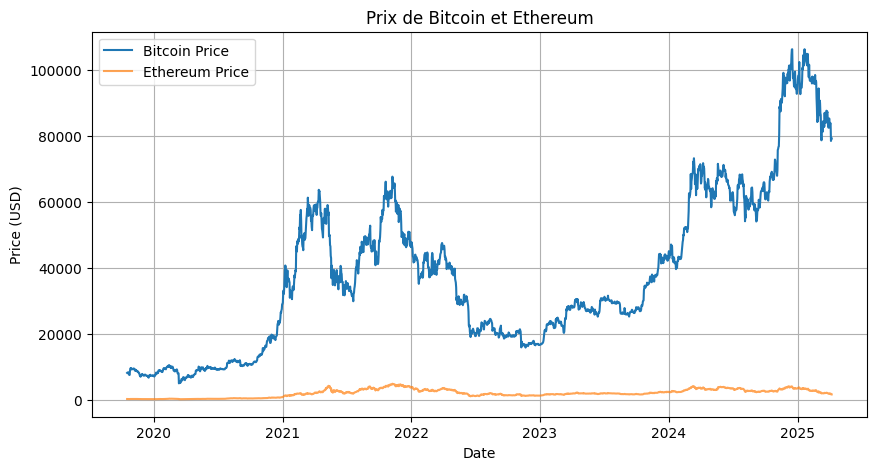

In [26]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import time

# Fonction pour récupérer les données historiques de CryptoCompare
def collect_data_crypto_compare(crypto_symbol, start_timestamp, end_timestamp):
    url = f'https://min-api.cryptocompare.com/data/v2/histoday'
    params = {
        'fsym': crypto_symbol,  # Symbole de la cryptomonnaie (BTC ou ETH)
        'tsym': 'USD',  # Devise de comparaison
        'limit': 2000,  # Limite des jours à récupérer
        'toTs': end_timestamp,  # Timestamp de fin
        'extraParams': 'crypto_prediction'  # Paramètre optionnel pour l'identification de l'application
    }
    response = requests.get(url, params=params)

    if response.status_code == 200:
        data = response.json()['Data']['Data']
        df = pd.DataFrame(data)

        # Convertir les timestamps en dates lisibles
        df['time'] = pd.to_datetime(df['time'], unit='s')

        return df
    else:
        print(f"Erreur lors de la récupération des données: {response.status_code}")
        return None

# Obtenir la date d'aujourd'hui sous forme de timestamp
today = datetime.today()
end_timestamp = int(time.mktime(today.timetuple()))

# Exemple de timestamp pour début (en secondes)
start_timestamp = 1614556800  # (par exemple, début de l'année 2021)

# Collecter les données de Bitcoin et Ethereum
bitcoin_data = collect_data_crypto_compare('BTC', start_timestamp, end_timestamp)
ethereum_data = collect_data_crypto_compare('ETH', start_timestamp, end_timestamp)

# Vérification que les données ont été récupérées correctement
if bitcoin_data is not None:
    print("Bitcoin Data:")
    print(bitcoin_data.head())

if ethereum_data is not None:
    print("Ethereum Data:")
    print(ethereum_data.head())

# Tracer les prix de Bitcoin et Ethereum
plt.figure(figsize=(10, 5))
plt.plot(bitcoin_data['time'], bitcoin_data['close'], label='Bitcoin Price')
plt.plot(ethereum_data['time'], ethereum_data['close'], label='Ethereum Price', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title('Prix de Bitcoin et Ethereum')
plt.legend()
plt.grid(True)
plt.show()


In [27]:
import warnings
warnings.filterwarnings('ignore')
import pmdarima as pm
import pandas as pd

# Série temporelle des prix de clôture de BTC
ts_data = bitcoin_data.set_index('time')['close']

# Recherche automatique du meilleur modèle ARIMA
best_model = pm.auto_arima(ts_data, seasonal=False, trace=True,
                           error_action='ignore', suppress_warnings=True)

# Afficher le résumé du modèle
print(best_model.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=34596.053, Time=1.78 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=34600.241, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=34595.689, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=34595.705, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=34599.566, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=34597.685, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=34597.690, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=34599.689, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=34595.184, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=34597.184, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=34597.187, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=34595.205, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=34599.187, Time=0.10 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 3.049 seconds
         

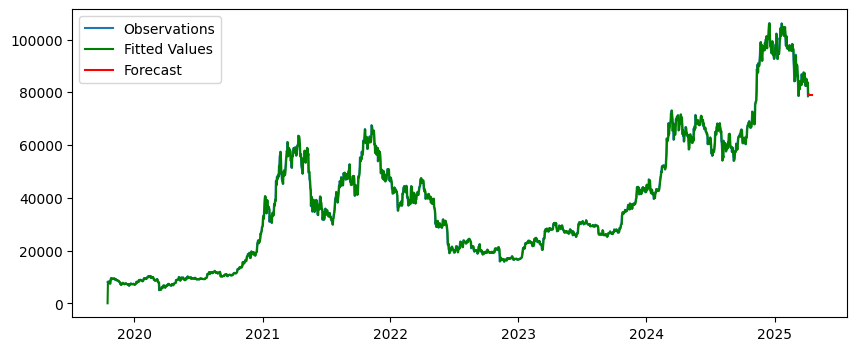

In [28]:
forecast=best_model.predict(n_periods=10)
plt.figure(figsize=(10,4))
plt.plot(ts_data,label='Observations')
plt.plot(best_model.predict_in_sample(),label='Fitted Values',color='green')
plt.plot(pd.date_range(ts_data.index[-1],periods=11,freq='D')[1:],forecast,label='Forecast',color='red')
plt.legend()
plt.show()

In [13]:
from statsmodels.tsa.arima.model import ARIMA
model=ARIMA(ts_data,order=(1,1,0))
model_fit=model.fit()
model_fit.summary()

/root/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/root/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/root/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  close   No. Observations:                 2001
Model:                 ARIMA(1, 1, 0)   Log Likelihood              -17295.592
Date:                Tue, 08 Apr 2025   AIC                          34595.183
Time:                        08:42:28   BIC                          34606.385
Sample:                    10-17-2019   HQIC                         34599.296
                         - 04-08-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0562      0.015     -3.834      0.000      -0.085      -0.027
sigma2      1.902e+06   3.08e+04     61.825      0.000    1.84e+06    1.96e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2668.20
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               2.02   Skew:                             0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [15]:
forecast = model_fit.forecast(steps=10)
print(forecast)

2025-04-09    79117.804713
2025-04-10    79117.720103
2025-04-11    79117.724860
2025-04-12    79117.724593
2025-04-13    79117.724608
2025-04-14    79117.724607
2025-04-15    79117.724607
2025-04-16    79117.724607
2025-04-17    79117.724607
2025-04-18    79117.724607
Freq: D, Name: predicted_mean, dtype: float64


In [21]:
import numpy as np
residuals = model_fit.resid

mae=np.mean(np.abs(residuals))
print("Mean Absolute Error: ",mae)
rmse=np.sqrt(np.mean(residuals**2))
print("Root Mean Squared Error: ",rmse)
mape=np.mean(np.abs(residuals)/ts_data[1:])*100
print("Mean Absolute Percentage Error: ",mape)

Mean Absolute Error:  849.9708041703416
Root Mean Squared Error:  1390.09393139153
Mean Absolute Percentage Error:  2.2603257821747538


In [56]:
import warnings
import pmdarima as pm

warnings.filterwarnings('ignore')

# Créer la série temporelle ETH (prix de clôture)
ts_eth = ethereum_data.set_index('time')['close']

# Appliquer auto_arima
best_model = pm.auto_arima(
    ts_eth,
    seasonal=False,  # désactiver la saisonnalité
    trace=True,      # afficher les étapes
    error_action='ignore',
    suppress_warnings=True
)

# Afficher le résumé du modèle
print(best_model.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=23783.162, Time=2.82 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=23807.759, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=23798.638, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=23799.074, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=23805.871, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=23800.374, Time=2.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=23800.810, Time=0.74 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=23804.581, Time=1.98 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=5.79 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=23800.395, Time=0.20 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=23801.571, Time=2.00 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=23801.607, Time=0.90 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=23782.922, Time=5.87 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=23800.932, Time=4.84 sec
 ARIMA(3,1,4)(0,0,0)[0] i

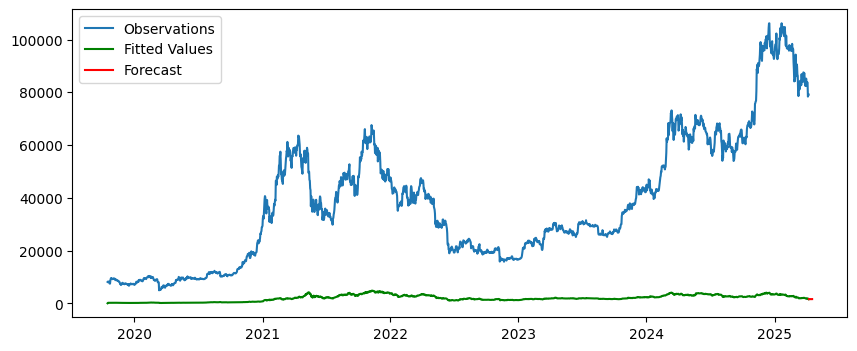

In [62]:
forecast=best_model.predict(n_periods=10)
plt.figure(figsize=(10,4))
plt.plot(ts_data,label='Observations')
plt.plot(best_model.predict_in_sample(),label='Fitted Values',color='green')
plt.plot(pd.date_range(ts_data.index[-1],periods=11,freq='D')[1:],forecast,label='Forecast',color='red')
plt.legend()
plt.show()

In [58]:
from statsmodels.tsa.arima.model import ARIMA
model=ARIMA(ts_data,order=(3,1,3))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  close   No. Observations:                 2001
Model:                 ARIMA(3, 1, 3)   Log Likelihood              -17291.952
Date:                Tue, 08 Apr 2025   AIC                          34597.904
Time:                        08:57:45   BIC                          34637.110
Sample:                    10-17-2019   HQIC                         34612.299
                         - 04-08-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1888      0.133     -1.416      0.157      -0.450       0.073
ar.L2         -0.0074      0.135     -0.054      0.957      -0.272       0.257
ar.L3         -0.6589      0.116     -5.664      0.000      -0.887      -0.431
ma.L1          0.1422      0.130      1.098      0.272      -0.112       0.396
ma.L2         -0.0193      0.125     -0.154      0.878      -0.265       0.226
ma.L3          0.6990      0.107      6.507      0.000       0.488       0.910
sigma2      1.902e+06   3.11e+04     61.065      0.000    1.84e+06    1.96e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):              2666.42
Prob(Q):                              0.61   Prob(JB):                         0.00
Heteroskedasticity (H):               2.01   Skew:                             0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 2001
Model:                 ARIMA(3, 1, 3)   Log Likelihood              -11883.442
Date:                Tue, 08 Apr 2025   AIC                          23780.884
Time:                        09:00:18   BIC                          23820.091
Sample:                    10-17-2019   HQIC                         23795.280
                         - 04-08-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0436      0.137     -7.641      0.000      -1.311      -0.776
ar.L2         -1.1592      0.038    -30.406      0.000      -1.234      -1.085
ar.L3         -0.7303      0.127     -5.729      0.0

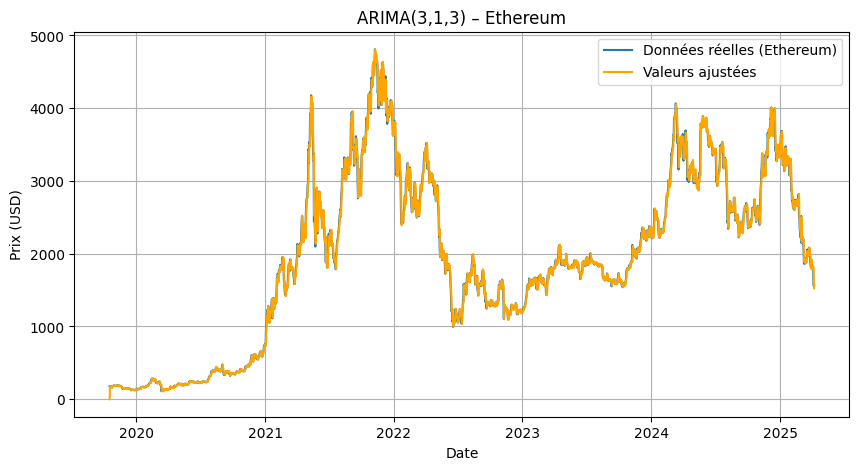

2025-04-09    1569.301491
2025-04-10    1588.370610
2025-04-11    1581.952785
2025-04-12    1562.533984
2025-04-13    1576.312011
2025-04-14    1589.131676
2025-04-15    1573.963599
2025-04-16    1564.869061
2025-04-17    1582.580689
2025-04-18    1585.717699
Freq: D, Name: predicted_mean, dtype: float64


In [65]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Préparer la série temporelle (Ethereum - prix de clôture)
ts_data = ethereum_data.set_index('time')['close']

# Créer le modèle ARIMA(3,1,3)
model = ARIMA(ts_data, order=(3,1,3))
model_fit = model.fit()

# Afficher le résumé du modèle
print(model_fit.summary())

# Tracer les valeurs ajustées vs réelles
plt.figure(figsize=(10, 5))
plt.plot(ts_data, label='Données réelles (Ethereum)')
plt.plot(ts_data.index, model_fit.fittedvalues, label='Valeurs ajustées', color='orange')  
plt.title('ARIMA(3,1,3) – Ethereum')
plt.xlabel('Date')
plt.ylabel('Prix (USD)')
plt.legend()
plt.grid(True)
plt.show()

# Prévoir les valeurs futures
forecast = model_fit.forecast(steps=10)
print(forecast)

In [67]:
import numpy as np
residuals = model_fit.resid

mae=np.mean(np.abs(residuals))
print("Mean Absolute Error: ",mae)
rmse=np.sqrt(np.mean(residuals**2))
print("Root Mean Squared Error: ",rmse)
mape=np.mean(np.abs(residuals)/ts_data[1:])*100
print("Mean Absolute Percentage Error: ",mape)

Mean Absolute Error:  56.3794553065523
Root Mean Squared Error:  92.14189490789074
Mean Absolute Percentage Error:  2.9952984322286618


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=086f6006-6b39-4457-8465-3f47189c2ecf' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>